# Figure 2

## Caption
Average surface temperature in A) May and C) August. Average phosphorous concentration in B) May and D) August. See Figure 1 caption for note on background phosphorus. 

In [8]:
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.size']=12
rcParams['xtick.labelsize']=12
rcParams['ytick.labelsize']=12
rcParams['axes.labelsize']=12
rcParams['axes.titlesize']=12

import numpy as np
import xarray as xr
import pandas as pd
import cmocean
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import from_levels_and_colors

from mpl_toolkits.axes_grid1 import AxesGrid
from cartopy.mpl.geoaxes import GeoAxes


# Load data

this should be in processing and a clean .nc in {dir_clean}

In [9]:
dir_raw = '/Users/gloege/Documents/Projects/MITgcm-Michigan-Phosphorus/data/raw/'
dir_clean = '/Users/gloege/Documents/Projects/MITgcm-Michigan-Phosphorus/data/clean/'

ds_phos = xr.open_mfdataset(f'{dir_raw}ptr_tave.*.data.nc')
ds_phos['T'] = pd.date_range(start='2007-01-01', end='2010-12-31', freq='1d')

In [10]:
ds_sst = xr.open_mfdataset(f'{dir_raw}tave.*.data.nc')
ds_sst['T'] = pd.date_range(start='2007-01-01', end='2010-12-31', freq='1d')

In [11]:
ds_grid = xr.open_dataset(f'{dir_raw}grid_lake_michigan.nc')

# Generate figure

Text(0.5,1,'August')

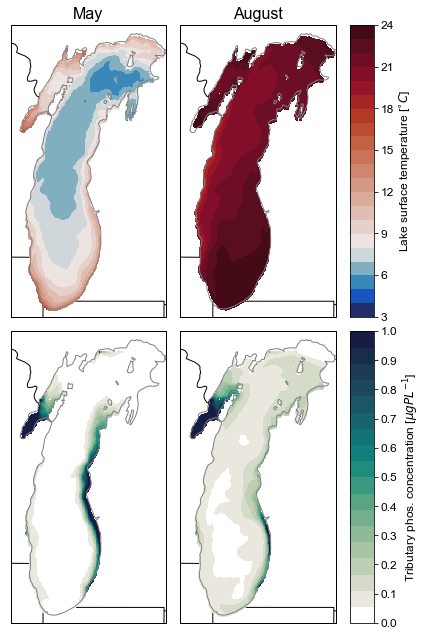

In [12]:
### ==============================================================
### Define grids
### ==============================================================
fig = plt.figure(figsize=(11, 11))
projection = ccrs.Mercator()
axes_class = (GeoAxes, dict(map_projection=projection))
grid = AxesGrid(fig, 111, axes_class=axes_class,
                share_all=False,
                nrows_ncols = (2, 2),
                axes_pad = 0.2,
                cbar_location = 'right',
                cbar_mode="edge",
                cbar_pad = 0.2,
                cbar_size = '15%',
                label_mode = '')  # note the empty label_mode

### ==============================================================
### Set boundary
### ==============================================================
for ax in grid:
    ax.set_extent([-84.75, -88.25, 41.5, 46.25]) ### Michigan


### ==============================================================
### Setup colorbar Temperature
### ==============================================================
num_levels = 22
vmin, vmax = 3, 24 
midpoint = 8
levels = np.linspace(vmin, vmax, num_levels)
midp = np.mean(np.c_[levels[:-1], levels[1:]], axis=1)
vals = np.interp(midp, [vmin, midpoint, vmax], [0, 0.5, 1])
colors = cmocean.cm.balance(vals)
cmap, norm = from_levels_and_colors(levels, colors)

sst_may = grid[0].pcolormesh(ds_sst['X'].values, ds_sst['Y'].values, 
                    ds_sst['sst'].where(ds_sst['T.month']==5).mean(['T','Z1']), 
                    cmap = cmap, 
                    vmin = vmin, 
                    vmax = vmax,
                    norm = norm,
                    zorder = 2,
                    transform=ccrs.PlateCarree())

sst_aug = grid[1].pcolormesh(ds_sst['X'].values, ds_sst['Y'].values, 
                    ds_sst['sst'].where(ds_sst['T.month']==8).mean(['T','Z1']), 
                    cmap = cmap, 
                    vmin = vmin, 
                    vmax = vmax,
                    norm = norm,
                    zorder = 2,
                    transform=ccrs.PlateCarree())

### ==============================================================
### Setup colorbar Temperature
### ==============================================================
vmin, vmax = 0, 1
cmap = cmocean.cm.tempo
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist[0] = (1,1,1,1.0)
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(vmin, vmax, 19)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

np.ma.masked_array(ds_phos['surface'].where(ds_phos['T.month']==5).mean(['T','Z1']),
                  mask=(ds_grid['Depth']==0))

phos_may = grid[2].pcolormesh(ds_phos['X'].values, ds_phos['Y'].values, 
                    np.ma.masked_array(ds_phos['surface'].\
                                       where(ds_phos['T.month']==5).mean(['T','Z1']),
                                       mask=(ds_grid['Depth']==0)),
                    cmap = cmap, 
                    vmin = vmin, 
                    vmax = vmax,
                    norm = norm,
                    zorder = 2,
                    transform=ccrs.PlateCarree())

phos_aug = grid[3].pcolormesh(ds_phos['X'].values, ds_phos['Y'].values, 
                    np.ma.masked_array(ds_phos['surface'].\
                                       where(ds_phos['T.month']==8).mean(['T','Z1']),
                                       mask=(ds_grid['Depth']==0)),
                    cmap = cmap, 
                    vmin = vmin, 
                    vmax = vmax,
                    norm = norm,
                    zorder = 2,
                    transform=ccrs.PlateCarree())
### ==============================================================
### Create a feature for States/Admin 1 
### regions at 1:50m from Natural Earth
### ==============================================================
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
for ax in grid:
    ax.add_feature(states_provinces, 
                   edgecolor='black', 
                   facecolor='none', 
                   zorder=1)


### ==============================================================
### Create a feature for lakes at 1:50m from Natural Earth
### ==============================================================
lakes_50m = cfeature.NaturalEarthFeature(
    category='physical',
    name='lakes',
    scale='10m',
    facecolor='none')
for ax in grid:
    ax.add_feature(lakes_50m, 
                   edgecolor=(0.5,0.5,0.5), 
                   facecolor='none', 
                   zorder=2)

### ==============================================================
### Add colorbar
### Better to use plt with reference to cax 
### than to grid.cbar_axes[0].colorbar(sub)
### since it is clunky as all get
### ==============================================================
cbar = plt.colorbar(sst_may, cax=grid.cbar_axes[0])
cbar.set_label(r'Lake surface temperature [$^{\circ} C$]', fontsize=12)
cbar.set_ticks(np.arange(3, 25, 3))
cbar.ax.tick_params(labelsize=12) 

cbar2 = plt.colorbar(phos_may, cax=grid.cbar_axes[1])
cbar2.set_label(r'Tributary phos. concentration [$\mu g P L^{-1}$]', fontsize=12)
cbar2.set_ticks(np.arange(0, 1.1, .1))
cbar2.ax.tick_params(labelsize=12) 


### ==============================================================
### Setup colorbar Temperature
### ==============================================================
grid[0].set_title('May', fontsize=16)
grid[1].set_title('August', fontsize=16)